In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

import warnings

warnings.simplefilter("ignore", UserWarning)

warnings.filterwarnings("ignore")

InteractiveShell.ast_node_interactivity = "all"

import sys

sys.path.append("../")
from helpers import *

KeyboardInterrupt: 

In [ ]:
pd.options.display.max_rows, pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option(
    "display.max_rows", None
)  # Print unlimited number of rows by setting to None, default is 10
pd.set_option(
    "display.max_columns", None
)  # Do not truncate columns to display all of them by setting to None
pd.set_option(
    "display.width", None
)  # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option(
    "display.max_colwidth", None
)  # Auto detect the max size of column and print contents of that column without truncation

(60, 20)

In [ ]:
X_train = pd.read_csv("../training_data/X_train_reduced.csv")
X_test = pd.read_csv("../training_data/X_test_reduced.csv")
y_train = pd.read_csv("../training_data/y_train.csv")
y_test = pd.read_csv("../training_data/y_test.csv")

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230633, 206), (76878, 206), (230633, 1), (76878, 1))

## Baseline Models

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import pandas as pd
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier


def evaluate_model(
    model, model_params, X_train, y_train, X_test, y_test, use_early_stopping=False
):
    # Adjust model with provided parameters
    model.set_params(**model_params)

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Check if the model supports early stopping
    if (
        use_early_stopping
        and hasattr(model, "fit")
        and "early_stopping_rounds" in model.get_params()
    ):
        model.fit(
            X_train_imputed,
            y_train,
            eval_set=[(X_test_imputed, y_test)],
            early_stopping_rounds=100,
            verbose=False,
        )
    else:
        model.fit(X_train_imputed, y_train)

    # Predictions
    y_pred = model.predict(X_test_imputed)
    y_pred_proba = (
        model.predict_proba(X_test_imputed)[:, 1]
        if hasattr(model, "predict_proba")
        else None
    )

    # Calculate metrics
    auc_score = (
        roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    )
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Convert the classification report into a DataFrame
    metrics_df = pd.DataFrame(report).transpose()

    # Add accuracy and potentially AUC to the DataFrame
    metrics_df.loc["Accuracy", "precision"] = accuracy
    if auc_score is not None:
        metrics_df.loc["AUC", "precision"] = auc_score
        metrics_df.loc["AUC", ["recall", "f1-score"]] = (
            np.nan
        )  # Set non-applicable columns as NaN

    # Add the model name in the df
    metrics_df["model"] = model.__class__.__name__

    return metrics_df

In [ ]:
# Correctly sampling the data
# X_train_sample = X_train.sample(50000, random_state=50)
# y_train_sample = y_train.loc[X_train_sample.index]  # Ensure the indices match

# X_test_sample = X_test.sample(50000, random_state=50)
# y_test_sample = y_test.loc[X_test_sample.index]  # Ensure the indices match


import time

start = time.time()
xgb_params = {"tree_method": "gpu_hist"}
xgb_metrics_df = evaluate_model(
    XGBClassifier(random_state=50), xgb_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[XGB] Time taken in seconds: ", end - start)

# RandomForestClassifier using 8 cores
start = time.time()
rf_params = {"n_jobs": -1}
rf_metrics_df = evaluate_model(
    RandomForestClassifier(random_state=50), rf_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[RF] Time taken in seconds: ", end - start)

# LightGBM
start = time.time()
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "seed": 50,
    "verbose": -1,
    "n_jobs": -1,
}
lgb_metrics_df = evaluate_model(
    lgb.LGBMClassifier(), lgb_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[LGBM] Time taken in seconds: ", end - start)

# CART (Decision Tree)
start = time.time()
cart_metrics_df = evaluate_model(
    DecisionTreeClassifier(random_state=50),
    {},
    X_train,
    y_train,
    X_test,
    y_test,
)
end = time.time()
print("[CART] Time taken in seconds: ", end - start)

# Extra Trees
start = time.time()
et_metrics_df = evaluate_model(
    ExtraTreesClassifier(random_state=50),
    {"n_jobs": -1},
    X_train,
    y_train,
    X_test,
    y_test,
)
end = time.time()
print("[ExtraTrees] Time taken in seconds: ", end - start)

# CatBoost
start = time.time()
catboost_params = {
    "task_type": "GPU",
    "devices": "0",  # Specifies the GPU ID to use. For multiple GPUs, use '0:1:2' for GPUs 0, 1, and 2, for example.
    "random_seed": 50,
    "silent": True,
}

# Evaluate CatBoost model
catboost_metrics_df = evaluate_model(
    CatBoostClassifier(), catboost_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[CB] Time taken in seconds: ", end - start)

# adaboost
start = time.time()
ada_metrics_df = evaluate_model(
    AdaBoostClassifier(random_state=50),
    {},
    X_train,
    y_train,
    X_test,
    y_test,
)
end = time.time()
print("[ADA] Time taken in seconds: ", end - start)

# ID3
start = time.time()
dt_params = {"criterion": "entropy", "random_state": 50}
id3_metrics_df = evaluate_model(
    DecisionTreeClassifier(), dt_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[ID3] Time taken in seconds: ", end - start)
print(id3_metrics_df)

xgb_metrics_df
rf_metrics_df
lgb_metrics_df
catboost_metrics_df
et_metrics_df
cart_metrics_df
ada_metrics_df
id3_metrics_df

[XGB] Time taken in seconds:  2.6991944313049316
[RF] Time taken in seconds:  15.191930055618286
[LGBM] Time taken in seconds:  2.712428569793701
[CART] Time taken in seconds:  34.59543538093567
[ExtraTrees] Time taken in seconds:  11.904861211776733
[CB] Time taken in seconds:  9.749132871627808
[ADA] Time taken in seconds:  55.60933876037598
[ID3] Time taken in seconds:  21.372390270233154
              precision    recall  f1-score       support  \
0              0.927092  0.918344  0.922698  70687.000000   
1              0.158355  0.175416  0.166450   6191.000000   
accuracy       0.858516  0.858516  0.858516      0.858516   
macro avg      0.542724  0.546880  0.544574  76878.000000   
weighted avg   0.865186  0.858516  0.861797  76878.000000   
Accuracy       0.858516       NaN       NaN           NaN   
AUC            0.546880       NaN       NaN           NaN   

                               model  
0             DecisionTreeClassifier  
1             DecisionTreeClassifier  

,precision,recall,f1-score,support,model
0,0.923981,0.993521,0.957490,70687.000000,XGBClassifier
1,0.474168,0.066710,0.116964,6191.000000,XGBClassifier
accuracy,0.918884,0.918884,0.918884,0.918884,XGBClassifier
macro avg,0.699074,0.530115,0.537227,76878.000000,XGBClassifier
weighted avg,0.887757,0.918884,0.889802,76878.000000,XGBClassifier
Accuracy,0.918884,NaN,NaN,NaN,XGBClassifier
AUC,0.775051,NaN,NaN,NaN,XGBClassifier


,precision,recall,f1-score,support,model
0,0.919949,0.999519,0.958085,70687.000000,RandomForestClassifier
1,0.558442,0.006946,0.013720,6191.000000,RandomForestClassifier
accuracy,0.919587,0.919587,0.919587,0.919587,RandomForestClassifier
macro avg,0.739195,0.503232,0.485903,76878.000000,RandomForestClassifier
weighted avg,0.890837,0.919587,0.882035,76878.000000,RandomForestClassifier
Accuracy,0.919587,NaN,NaN,NaN,RandomForestClassifier
AUC,0.742690,NaN,NaN,NaN,RandomForestClassifier


,precision,recall,f1-score,support,model
0,0.922155,0.997298,0.958256,70687.000000,LGBMClassifier
1,0.556845,0.038766,0.072486,6191.000000,LGBMClassifier
accuracy,0.920107,0.920107,0.920107,0.920107,LGBMClassifier
macro avg,0.739500,0.518032,0.515371,76878.000000,LGBMClassifier
weighted avg,0.892737,0.920107,0.886925,76878.000000,LGBMClassifier
Accuracy,0.920107,NaN,NaN,NaN,LGBMClassifier
AUC,0.780845,NaN,NaN,NaN,LGBMClassifier


,precision,recall,f1-score,support,model
0,0.921876,0.997935,0.958398,70687.000000,CatBoostClassifier
1,0.593315,0.034405,0.065038,6191.000000,CatBoostClassifier
accuracy,0.920341,0.920341,0.920341,0.920341,CatBoostClassifier
macro avg,0.757595,0.516170,0.511718,76878.000000,CatBoostClassifier
weighted avg,0.895417,0.920341,0.886456,76878.000000,CatBoostClassifier
Accuracy,0.920341,NaN,NaN,NaN,CatBoostClassifier
AUC,0.782704,NaN,NaN,NaN,CatBoostClassifier


,precision,recall,f1-score,support,model
0,0.919755,0.999816,0.958116,70687.000000,ExtraTreesClassifier
1,0.657895,0.004038,0.008027,6191.000000,ExtraTreesClassifier
accuracy,0.919626,0.919626,0.919626,0.919626,ExtraTreesClassifier
macro avg,0.788825,0.501927,0.483072,76878.000000,ExtraTreesClassifier
weighted avg,0.898668,0.919626,0.881605,76878.000000,ExtraTreesClassifier
Accuracy,0.919626,NaN,NaN,NaN,ExtraTreesClassifier
AUC,0.747302,NaN,NaN,NaN,ExtraTreesClassifier


,precision,recall,f1-score,support,model
0,0.926924,0.914624,0.920733,70687.000000,DecisionTreeClassifier
1,0.153458,0.176708,0.164264,6191.000000,DecisionTreeClassifier
accuracy,0.855199,0.855199,0.855199,0.855199,DecisionTreeClassifier
macro avg,0.540191,0.545666,0.542498,76878.000000,DecisionTreeClassifier
weighted avg,0.864636,0.855199,0.859814,76878.000000,DecisionTreeClassifier
Accuracy,0.855199,NaN,NaN,NaN,DecisionTreeClassifier
AUC,0.545666,NaN,NaN,NaN,DecisionTreeClassifier


,precision,recall,f1-score,support,model
0,0.921549,0.997411,0.957980,70687.000000,AdaBoostClassifier
1,0.508065,0.030528,0.057596,6191.000000,AdaBoostClassifier
accuracy,0.919548,0.919548,0.919548,0.919548,AdaBoostClassifier
macro avg,0.714807,0.513970,0.507788,76878.000000,AdaBoostClassifier
weighted avg,0.888251,0.919548,0.885472,76878.000000,AdaBoostClassifier
Accuracy,0.919548,NaN,NaN,NaN,AdaBoostClassifier
AUC,0.762426,NaN,NaN,NaN,AdaBoostClassifier


,precision,recall,f1-score,support,model
0,0.927092,0.918344,0.922698,70687.000000,DecisionTreeClassifier
1,0.158355,0.175416,0.166450,6191.000000,DecisionTreeClassifier
accuracy,0.858516,0.858516,0.858516,0.858516,DecisionTreeClassifier
macro avg,0.542724,0.546880,0.544574,76878.000000,DecisionTreeClassifier
weighted avg,0.865186,0.858516,0.861797,76878.000000,DecisionTreeClassifier
Accuracy,0.858516,NaN,NaN,NaN,DecisionTreeClassifier
AUC,0.546880,NaN,NaN,NaN,DecisionTreeClassifier


- [XGB] Time taken in seconds:  2.3660011291503906
- [RF] Time taken in seconds:  15.208309412002563
- [LGBM] Time taken in seconds:  2.58160662651062
- [CART] Time taken in seconds:  34.42043113708496
- [ExtraTrees] Time taken in seconds:  11.579836368560791
- [CB] Time taken in seconds:  9.541874170303345
- [ADA] Time taken in seconds:  55.95080637931824

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import pandas as pd
import numpy as np
import lightgbm as lgb

def evaluate_model_with_smote(
    model, model_params, X_train, y_train, X_test, y_test, use_early_stopping=False
):
    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    # Initialize SMOTE
    smote = SMOTE(random_state=50)
    
    # Create a pipeline that first oversamples then fits the model
    pipeline = ImbPipeline(steps=[('smote', smote), ('model', model)])
    
    # Adjust model with provided parameters
    model_params_prefixed = {f'model__{k}': v for k, v in model_params.items()}
    pipeline.set_params(**model_params_prefixed)

    # Check if the model supports early stopping
    if use_early_stopping and 'early_stopping_rounds' in model_params:
        early_stopping_params = {
            'model__early_stopping_rounds': model_params['early_stopping_rounds'],
            'model__eval_set': [(X_test_imputed, y_test)],
            'model__verbose': False,
        }
        pipeline.set_params(**early_stopping_params)
        model_params_prefixed.pop('model__early_stopping_rounds', None)  # Remove from the params to avoid double setting
        pipeline.fit(X_train_imputed, y_train)
    else:
        pipeline.fit(X_train_imputed, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test_imputed)
    y_pred_proba = pipeline.predict_proba(X_test_imputed)[:, 1] if hasattr(pipeline.named_steps['model'], "predict_proba") else None

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Convert the classification report into a DataFrame
    metrics_df = pd.DataFrame(report).transpose()

    # Add accuracy and potentially AUC to the DataFrame
    metrics_df.loc["Accuracy", "precision"] = accuracy
    if auc_score is not None:
        metrics_df.loc["AUC", "precision"] = auc_score
        metrics_df.loc["AUC", ["recall", "f1-score", "support"]] = np.nan  # Set non-applicable columns as NaN

    # Add the model name in the df
    metrics_df["model"] = model.__class__.__name__

    return metrics_df

# Now you can use this function to evaluate LightGBM with SMOTE.
# Here is an example of how you might call the function with LightGBM model:
lgb_params_with_smote = {
    'objective': 'binary',
    'metric': 'auc',
    'seed': 50,
    'verbose': -1,
    'n_jobs': -1,
}
lgb_metrics_df_with_smote = evaluate_model_with_smote(
    lgb.LGBMClassifier(),
    lgb_params_with_smote,
    X_train,
    y_train,
    X_test,
    y_test,
    use_early_stopping=True
)
lgb_metrics_df_with_smote
# Make sure to replace X_train, y_train, X_test, and y_test with your actual data.



,precision,recall,f1-score,support,model
0,0.921336,0.997468,0.957892,70687.000000,LGBMClassifier
1,0.488571,0.027621,0.052286,6191.000000,LGBMClassifier
accuracy,0.919366,0.919366,0.919366,0.919366,LGBMClassifier
macro avg,0.704954,0.512544,0.505089,76878.000000,LGBMClassifier
weighted avg,0.886485,0.919366,0.884963,76878.000000,LGBMClassifier
Accuracy,0.919366,NaN,NaN,NaN,LGBMClassifier
AUC,0.772978,NaN,NaN,NaN,LGBMClassifier


In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# Assume `X_test` is your test set and `lgbm_model` is your trained LightGBM model
# You can obtain the probability predictions for each class using the `predict_proba` function
lgbm_model = lgb.LGBMClassifier(  
    objective='binary', # binary classification
    random_state=50, # Random seed
    n_jobs=-1, 
    n_estimators=3000,
    learning_rate=0.05,
)

lgbm_model.fit(X_train, y_train)

probs = lgbm_model.predict_proba(X_test)

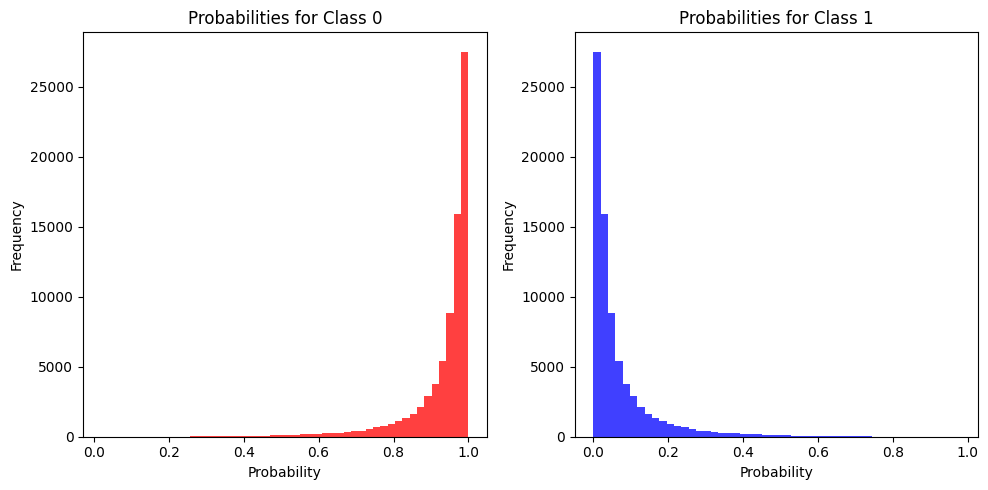

In [ ]:

# Obtain the probability predictions for the test set
probs = lgbm_model.predict_proba(X_test)

# Plotting the probabilities
plt.figure(figsize=(10, 5))

# Plot for class 0
plt.subplot(1, 2, 1)
plt.hist(probs[:, 0], bins=50, alpha=0.75, color='red')
plt.title('Probabilities for Class 0')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Plot for class 1
plt.subplot(1, 2, 2)
plt.hist(probs[:, 1], bins=50, alpha=0.75, color='blue')
plt.title('Probabilities for Class 1')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show();

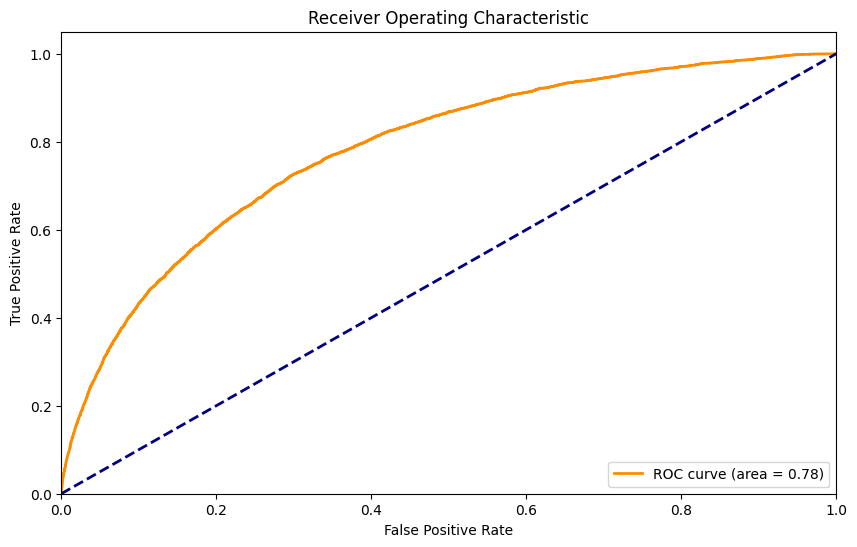

In [ ]:
from sklearn.metrics import roc_curve, auc

probs = lgbm_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

roc_auc = auc(fpr, tpr)

# Finally, you'd plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show();

#### Baseline models
<img src="../images/baseline_1.png" alt="Alternative text" />
<img src="../images/baseline_2.png" alt="Alternative text" />


#### GBDT vs DART vs GOSS

In [ ]:
lgb_params = {
    "seed": 50,
    "verbose": -1,
    "boosting_type": "gbdt",
    "metric": "auc",
    "n_estimators": 10000,
    "learning_rate": 0.005134,
    "num_leaves": 54,
    "max_depth": 10,
    "subsample_for_bin": 240000,
    "reg_alpha": 0.436193,
    "reg_lambda": 0.479169,
    "colsample_bytree": 0.508716,
    "min_split_gain": 0.024766,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}
lgb_params_dart = {
    "seed": 50,
    "verbose": -1,
    "boosting_type": "dart",
    "metric": "auc",
    "n_estimators": 10000,
    "learning_rate": 0.005134,
    "num_leaves": 54,
    "max_depth": 10,
    "subsample_for_bin": 240000,
    "reg_alpha": 0.436193,
    "reg_lambda": 0.479169,
    "colsample_bytree": 0.508716,
    "min_split_gain": 0.024766,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}
lgb_params_goss = {
    "seed": 50,
    "verbose": -1,
    "boosting_type": "goss",
    "metric": "auc",
    "n_estimators": 10000,
    "learning_rate": 0.005134,
    "num_leaves": 54,
    "max_depth": 10,
    "subsample_for_bin": 240000,
    "reg_alpha": 0.436193,
    "reg_lambda": 0.479169,
    "colsample_bytree": 0.508716,
    "min_split_gain": 0.024766,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}


# # LightGBM
# X_train_sample = X_train.sample(50000, random_state=50)
# y_train_sample = y_train.loc[X_train_sample.index]  # Ensure the indices match

# X_test_sample = X_test.sample(50000, random_state=50)
# y_test_sample = y_test.loc[X_test_sample.index]  # Ensure the indices match

# LightGBM with gbdt - Gradient Boosting Decision Tree
start = time.time()
lgb_metrics_df = evaluate_model(
    lgb.LGBMClassifier(), lgb_params, X_train, y_train, X_test, y_test
)
end = time.time()
print("[LGBM-GBDT] Time taken in seconds: ", end - start)

# LGBM with dart - Dropouts meet Multiple Additive Regression Trees
start = time.time()
lgb_metrics_dart_df = evaluate_model(
    lgb.LGBMClassifier(), lgb_params_dart, X_train, y_train, X_test, y_test
)
end = time.time()
print("[LGBM-DART] Time taken in seconds: ", end - start)

# LGBM with goss - Gradient-based One-Side Sampling
start = time.time()
lgb_metrics_goss_df = evaluate_model(
    lgb.LGBMClassifier(), lgb_params_goss, X_train, y_train, X_test, y_test
)
end = time.time()
print("[LGBM-GOSS] Time taken in seconds: ", end - start)

[LGBM-GBDT] Time taken in seconds:  141.92781138420105
[LGBM-DART] Time taken in seconds:  800.2997543811798
[LGBM-GOSS] Time taken in seconds:  184.16848945617676


In [ ]:
lgb_metrics_df
lgb_metrics_dart_df
lgb_metrics_goss_df

,precision,recall,f1-score,support,model
0,0.923092,0.996548,0.958415,70687.000000,LGBMClassifier
1,0.568905,0.052011,0.095309,6191.000000,LGBMClassifier
accuracy,0.920484,0.920484,0.920484,0.920484,LGBMClassifier
macro avg,0.745998,0.524280,0.526862,76878.000000,LGBMClassifier
weighted avg,0.894569,0.920484,0.888909,76878.000000,LGBMClassifier
Accuracy,0.920484,NaN,NaN,NaN,LGBMClassifier
AUC,0.790354,NaN,NaN,NaN,LGBMClassifier


,precision,recall,f1-score,support,model
0,0.921641,0.998359,0.958467,70687.000000,LGBMClassifier
1,0.622150,0.030851,0.058787,6191.000000,LGBMClassifier
accuracy,0.920445,0.920445,0.920445,0.920445,LGBMClassifier
macro avg,0.771896,0.514605,0.508627,76878.000000,LGBMClassifier
weighted avg,0.897523,0.920445,0.886016,76878.000000,LGBMClassifier
Accuracy,0.920445,NaN,NaN,NaN,LGBMClassifier
AUC,0.789556,NaN,NaN,NaN,LGBMClassifier


,precision,recall,f1-score,support,model
0,0.923111,0.996477,0.958392,70687.000000,LGBMClassifier
1,0.565445,0.052334,0.095801,6191.000000,LGBMClassifier
accuracy,0.920445,0.920445,0.920445,0.920445,LGBMClassifier
macro avg,0.744278,0.524406,0.527097,76878.000000,LGBMClassifier
weighted avg,0.894308,0.920445,0.888928,76878.000000,LGBMClassifier
Accuracy,0.920445,NaN,NaN,NaN,LGBMClassifier
AUC,0.789816,NaN,NaN,NaN,LGBMClassifier


## XGB fine-tuning


Iteration completed in 72.78 seconds.
Best score so far: 0.7801
Best parameters so far:
colsample_bylevel: 0.705051979426657
colsample_bynode: 0.8638628715886625
colsample_bytree: 0.966433999423917
gamma: 1.5789979674352437
learning_rate: 0.07956180701453125
max_depth: 6
min_child_weight: 2
n_estimators: 766
reg_alpha: 0.0003329021156509417
reg_lambda: 0.4444179465307111
subsample: 0.9324945912714676

Iteration completed in 34.46 seconds.
Best score so far: 0.7849
Best parameters so far:
colsample_bylevel: 0.9186941777766422
colsample_bynode: 0.9416576386904312
colsample_bytree: 0.6517050549420875
gamma: 4.756119532966647
learning_rate: 0.09101195155623103
max_depth: 3
min_child_weight: 2
n_estimators: 418
reg_alpha: 0.015088480620326387
reg_lambda: 0.898421528488311
subsample: 0.9444851599721785

Iteration completed in 68.88 seconds.
Best score so far: 0.7851
Best parameters so far:
colsample_bylevel: 0.7224162561505759
colsample_bynode: 0.9593612608346885
colsample_bytree: 0.5524295

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'min_child_weight': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-05, high=1.0, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.1, high=1.0, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.85, high=1.0, prior='uniform', transform='normalize')})

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Improvement of Best AUC Score over Iterations')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Best AUC Score')

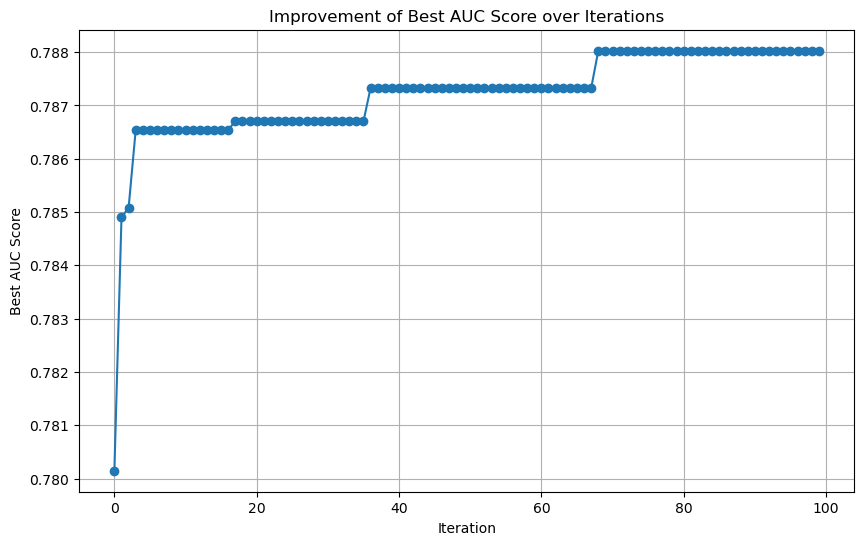

In [ ]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeltaYStopper
import time
import matplotlib.pyplot as plt


class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        # Lists to store scores and parameter sets
        self.best_scores = []
        self.best_parameters = []

    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")

        # Store the negated best score so far to correct its sign
        best_score_so_far = -res.fun
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        # Extract and store the best parameters so far
        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Initialize the callback
iteration_callback = IterationTrackingCallback()

# Define your XGBClassifier and BayesSearchCV as before
model = XGBClassifier(tree_method="gpu_hist", random_state=42)

search_spaces = {
    "n_estimators": Integer(100, 1000),
    "max_depth": Integer(3, 10),
    "learning_rate": Real(0.05, 0.1, "log-uniform"),
    "subsample": Real(0.85, 1.0),
    "colsample_bytree": Real(0.5, 1.0),
    "colsample_bylevel": Real(0.5, 1.0),  # Added based on your current range
    "colsample_bynode": Real(0.5, 1.0),  # Added for experimentation
    "min_child_weight": Integer(1, 5),
    "gamma": Real(0, 5),
    "reg_alpha": Real(1e-05, 1.0, "log-uniform"),
    "reg_lambda": Real(0.1, 1.0, "log-uniform"),
}


# Define your XGBClassifier and BayesSearchCV as before
model = XGBClassifier(tree_method="gpu_hist", random_state=42)
opt = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=100,  # Reduced iterations for speed
    scoring="roc_auc",
    cv=5,
    n_jobs=1,  # Keep as 1 for GPU usage
    return_train_score=True,
    refit=True,
    random_state=42,
)
# Fit BayesSearchCV with the callback
opt.fit(X_train, y_train, callback=[iteration_callback])


# Plotting the improvement of scores
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback.best_scores, marker="o")
plt.title("Improvement of Best AUC Score over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best AUC Score")
plt.grid(True)
plt.show()

<img src="../images/XGB_AUC_scores.png" alt="Alternative text" />

**XGB Finetune results**

**AUC: 0.7880**

Best parameters:
- colsample_bylevel: 0.7566586325362956
- colsample_bynode: 1.0
- colsample_bytree: 0.8699617922932693
- gamma: 0.0
- learning_rate: 0.05
- max_depth: 4
- min_child_weight: 1
- n_estimators: 1200
- reg_alpha: 1.0
- reg_lambda: 1.0
- subsample: 0.9100477231276671

### XGB Kfold

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc
 
xgb_params = {
    "tree_method": "gpu_hist",
    "colsample_bylevel": 0.7566586325362956,
    "colsample_bynode": 1.0,
    "colsample_bytree": 0.8699617922932693,
    "gamma": 0,
    "learning_rate": 0.05,
    "max_depth": 4,
    "min_child_weight": 1,
    "n_estimators": 1200,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "subsample": 0.9100477231276671,
    "use_label_encoder": False,
}


def kfold_xgboost_sklearn(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    NUM_FOLDS=5,
    RANDOM_SEED=50,
    STRATIFIED_KFOLD=False,
    XGB_PARAMS={},
):
    print(f"Train/valid shape: {X_train.shape, y_train.shape}")

    folds = (
        StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        if STRATIFIED_KFOLD
        else KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    )

    oof_preds = np.zeros(X_train.shape[0])
    importance_df = pd.DataFrame()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = XGBClassifier(**XGB_PARAMS, random_state=RANDOM_SEED)
        clf.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            eval_metric="auc",
            verbose=400,
            early_stopping_rounds=100,
        )

        proba_preds_valid = clf.predict_proba(valid_x)
        oof_preds[valid_idx] = (
            proba_preds_valid[:, 1]
            if proba_preds_valid.shape[1] > 1
            else proba_preds_valid[:, 0]
        )

        fold_importance = pd.DataFrame(
            {
                "feature": train_x.columns.tolist(),
                "gain": clf.feature_importances_,
                "fold": n_fold + 1,
            }
        )
        importance_df = pd.concat([importance_df, fold_importance], axis=0)

        print(
            "Fold %2d AUC : %.6f"
            % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]))
        )
        gc.collect()

    print("Full AUC score %.6f" % roc_auc_score(y_train, oof_preds))

    if X_test is not None and y_test is not None:
        test_preds = clf.predict_proba(X_test)[:, 1]
        print("Test AUC score: %.6f" % roc_auc_score(y_test, test_preds))

    return (
        importance_df.groupby("feature")
        .gain.mean()
        .sort_values(ascending=False)
        .reset_index()
    )


feat_importance = kfold_xgboost_sklearn(
    X_train,
    y_train,
    X_test,
    y_test,
    NUM_FOLDS=10,
    STRATIFIED_KFOLD=False,
    XGB_PARAMS=xgb_params,
)
print(feat_importance)

Train/valid shape: ((230633, 206), (230633, 1))


[0]	validation_0-auc:0.70618
[400]	validation_0-auc:0.78419
[800]	validation_0-auc:0.78839
[1015]	validation_0-auc:0.78878
Fold  1 AUC : 0.788864
[0]	validation_0-auc:0.71209
[400]	validation_0-auc:0.78830
[800]	validation_0-auc:0.79197
[1128]	validation_0-auc:0.79242
Fold  2 AUC : 0.792729
[0]	validation_0-auc:0.69796
[400]	validation_0-auc:0.77629
[800]	validation_0-auc:0.78142
[1199]	validation_0-auc:0.78229
Fold  3 AUC : 0.782363
[0]	validation_0-auc:0.69944
[400]	validation_0-auc:0.78611
[800]	validation_0-auc:0.79121
[1025]	validation_0-auc:0.79201
Fold  4 AUC : 0.792122
[0]	validation_0-auc:0.70621
[400]	validation_0-auc:0.78621
[800]	validation_0-auc:0.79095
[1199]	validation_0-auc:0.79228
Fold  5 AUC : 0.792409
[0]	validation_0-auc:0.70113
[400]	validation_0-auc:0.78085
[800]	validation_0-auc:0.78497
[1114]	validation_0-auc:0.78513
Fold  6 AUC : 0.785274
[0]	validation_0-auc:0.70664
[400]	validation_0-auc:0.78481
[800]	validation_0-auc:0.78864
[1132]	validation_0-auc:0.78856
F

- Full AUC score 0.789425
- Test AUC score: 0.789143

<Figure size 1400x1000 with 0 Axes>

<Axes: xlabel='gain', ylabel='feature'>

Text(0.5, 1.0, 'XGBClassifier - Feature Importance')

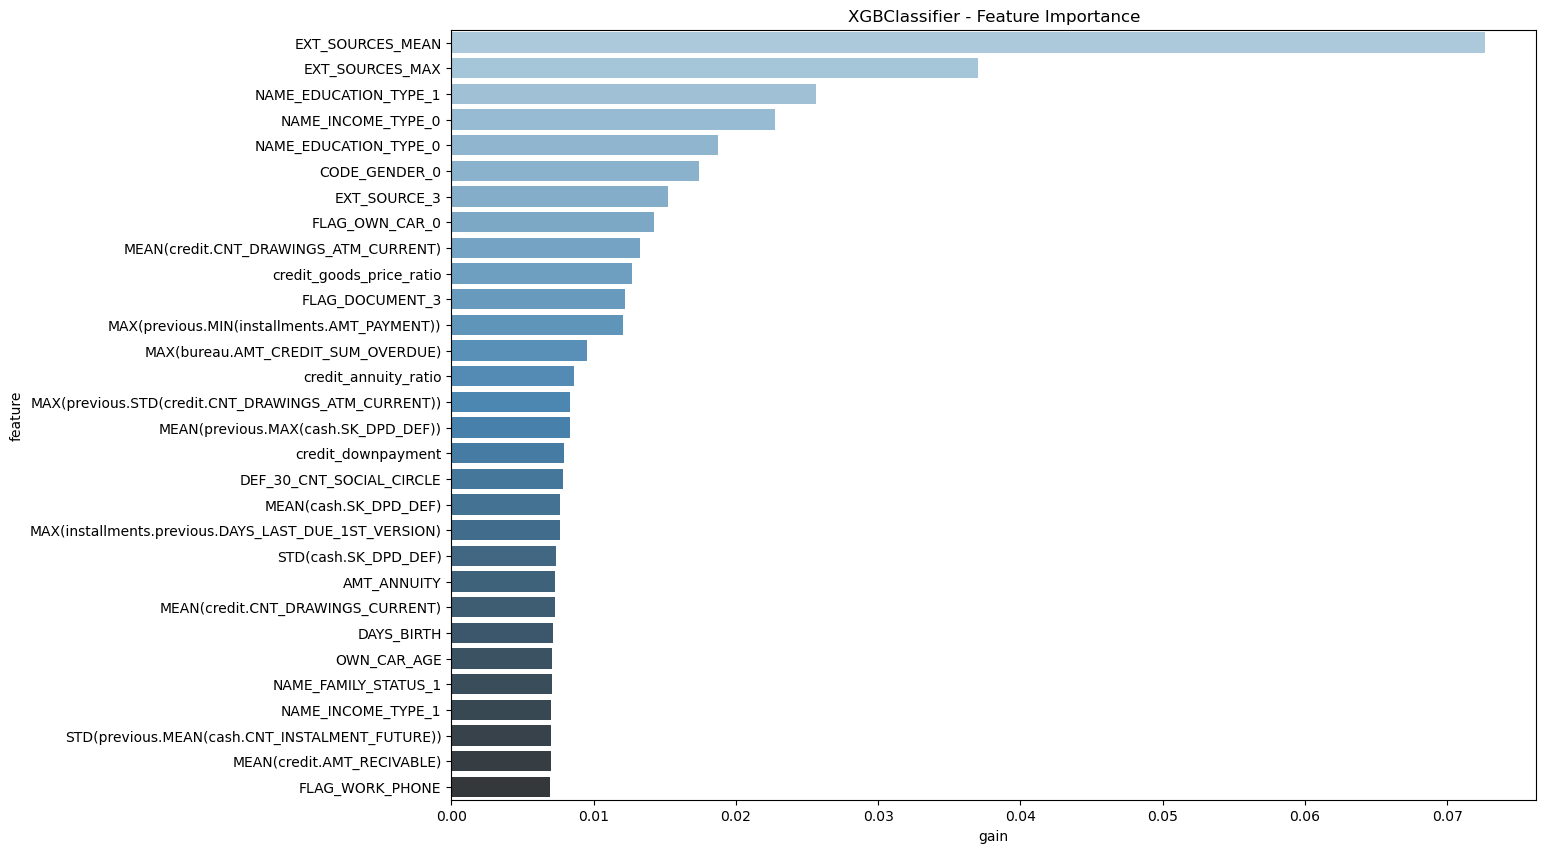

In [ ]:
# plot top 30 feat_importance
plt.figure(figsize=(14, 10))
sns.barplot(
    x="gain",
    y="feature",
    data=feat_importance.sort_values(by="gain", ascending=False)[:30],
    palette="Blues_d",

)
plt.title("XGBClassifier - Feature Importance")
plt.show()

## LGBM Finetuning


Iteration completed in 267.52 seconds.
Best score so far: 0.7869
Best parameters so far:
colsample_bytree: 0.48202079177066276
learning_rate: 0.0053422688874711095
max_depth: 11
min_split_gain: 0.019473987804611462
n_estimators: 3681
num_leaves: 32
reg_alpha: 0.48074506791931526
reg_lambda: 0.8176529639332943
subsample: 0.8608926622073013

Iteration completed in 168.24 seconds.
Best score so far: 0.7869
Best parameters so far:
colsample_bytree: 0.48202079177066276
learning_rate: 0.0053422688874711095
max_depth: 11
min_split_gain: 0.019473987804611462
n_estimators: 3681
num_leaves: 32
reg_alpha: 0.48074506791931526
reg_lambda: 0.8176529639332943
subsample: 0.8608926622073013

Iteration completed in 109.86 seconds.
Best score so far: 0.7869
Best parameters so far:
colsample_bytree: 0.48202079177066276
learning_rate: 0.0053422688874711095
max_depth: 11
min_split_gain: 0.019473987804611462
n_estimators: 3681
num_leaves: 32
reg_alpha: 0.48074506791931526
reg_lambda: 0.8176529639332943
subs

BayesSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=100,
              n_jobs=-1, random_state=42, return_train_score=True,
              scoring='roc_auc',
              search_spaces={'colsample_bytree': Real(low=0.4, high=0.6, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.001, high=0.01, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=4, high=...
                             'n_estimators': Integer(low=1000, high=5000, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=5, high=70, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.2, high=1, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.3, high=1, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.8, high=1.0, prior='uniform', transform='normalize')})

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Improvement of Best AUC Score over Iterations for LightGBM')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Best AUC Score')

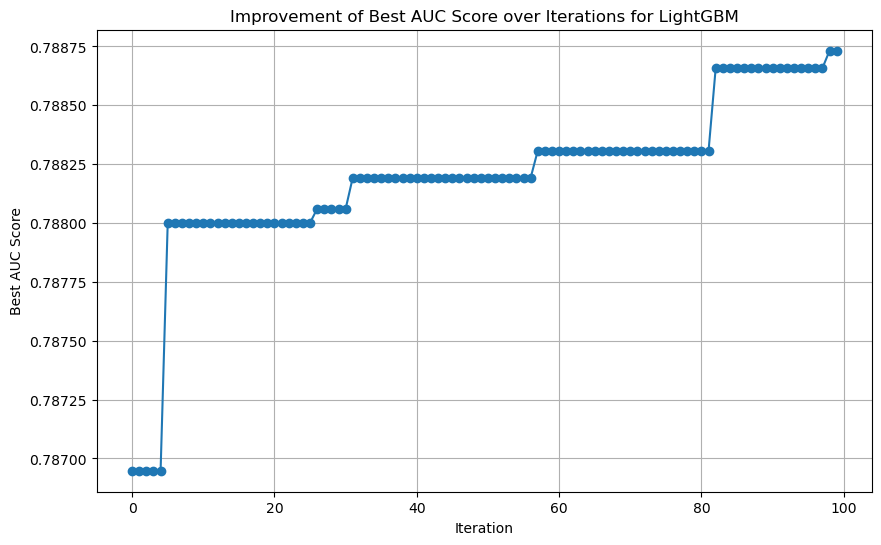

In [ ]:
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeltaYStopper
import time
import matplotlib.pyplot as plt
import numpy as np


class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        self.best_scores = []
        self.best_parameters = []

    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")

        best_score_so_far = (
            -res.fun
        )  
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Assuming X_train and y_train are already defined

# Initialize the callback for LightGBM
iteration_callback_lgbm = IterationTrackingCallback()

# Define the LGBMClassifier
model_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Define the search space for LightGBM
search_spaces_lgbm = {
    "n_estimators": Integer(1000, 5000), 
    "learning_rate": Real(0.001, 0.01, "log-uniform"),  
    "num_leaves": Integer(5, 70),  
    "max_depth": Integer(4, 12),  
    "reg_alpha": Real(0.2, 1),  # Centered around 0.436193
    "reg_lambda": Real(0.3, 1),  # Centered around 0.479169
    "colsample_bytree": Real(0.4, 0.6),  # Centered around 0.508716
    "min_split_gain": Real(0.01, 0.04),  # Centered around 0.024766
    "subsample": Real(
        0.8, 1.0
    ),  # Fixed to 1 based on your parameters, might not need optimization
}

# Set up BayesSearchCV for LightGBM
opt_lgbm = BayesSearchCV(
    estimator=model_lgbm,
    search_spaces=search_spaces_lgbm,
    n_iter=100,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    refit=True,
    random_state=42,
)

# # If y_train is a pandas DataFrame with a single column:
# y_train = y_train.squeeze()  # This will convert it to a pandas Series

# # Alternatively:
# y_train = y_train.values.ravel()  # This will convert it to a 1D numpy array

# Now you can fit the model with y_train which is a 1D array-like object
opt_lgbm.fit(X_train, y_train, callback=[iteration_callback_lgbm])


# Plot the improvement of scores over iterations for LightGBM
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback_lgbm.best_scores, marker="o")
plt.title("Improvement of Best AUC Score over Iterations for LightGBM")
plt.xlabel("Iteration")
plt.ylabel("Best AUC Score")
plt.grid(True)
plt.show()

<img src="../images/LGBM_AUC_scores.png" alt="Alternative " />

**LGBM**

**Best score: 0.7887**
- colsample_bytree: 0.4
- learning_rate: 0.004955862989943362
- max_depth: 7
- min_split_gain: 0.04
- n_estimators: 5000
- num_leaves: 45
- reg_alpha: 1.0
- reg_lambda: 1.0

### LGBM Kfold

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc


def kfold_lightgbm_sklearn(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    NUM_FOLDS=5,
    RANDOM_SEED=50,
    STRATIFIED_KFOLD=False,
    LGBM_PARAMS={},
):
    print(f"Train/valid shape: {X_train.shape, y_train.shape}")

    folds = (
        StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        if STRATIFIED_KFOLD
        else KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    )

    oof_preds = np.zeros(X_train.shape[0])
    importance_df = pd.DataFrame()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = LGBMClassifier(**LGBM_PARAMS, random_state=RANDOM_SEED, n_jobs=-1)
        clf.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            eval_metric="auc",
            early_stopping_rounds=100,
            verbose=400,
            categorical_feature="auto",  # Auto-detect categorical features
        )

        proba_preds_valid = clf.predict_proba(
            valid_x, num_iteration=clf.best_iteration_
        )
        oof_preds[valid_idx] = (
            proba_preds_valid[:, 1]
            if proba_preds_valid.shape[1] > 1
            else proba_preds_valid[:, 0]
        )

        fold_importance = pd.DataFrame(
            {
                "feature": train_x.columns.tolist(),
                "gain": clf.feature_importances_,
                "fold": n_fold + 1,
            }
        )
        importance_df = pd.concat([importance_df, fold_importance], axis=0)

        print(
            "Fold %2d AUC : %.6f"
            % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]))
        )
        gc.collect()

    print("Full AUC score %.6f" % roc_auc_score(y_train, oof_preds))

    if X_test is not None and y_test is not None:
        test_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1]
        print("Test AUC score: %.6f" % roc_auc_score(y_test, test_preds))

    return (
        importance_df.groupby("feature")
        .gain.mean()
        .sort_values(ascending=False)
        .reset_index()
    )


LIGHTGBM_PARAMS = {
    "n_estimators": 11000,
    "learning_rate": 0.004955862989943362,
    "num_leaves": 45,
    "max_depth": 7,
    "subsample_for_bin": 240000,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "colsample_bytree": 0.4,
    "min_split_gain": 0.04,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}
feat_importance = kfold_lightgbm_sklearn(
    X_train,
    y_train,
    X_test,
    y_test,
    NUM_FOLDS=10,
    STRATIFIED_KFOLD=True,
    LGBM_PARAMS=LIGHTGBM_PARAMS,
)
print(feat_importance)

Train/valid shape: ((230633, 206), (230633, 1))
[400]	valid_0's auc: 0.757987	valid_0's binary_logloss: 0.249552
[800]	valid_0's auc: 0.766796	valid_0's binary_logloss: 0.24476
[1200]	valid_0's auc: 0.772259	valid_0's binary_logloss: 0.242733
[1600]	valid_0's auc: 0.775219	valid_0's binary_logloss: 0.241676
[2000]	valid_0's auc: 0.777202	valid_0's binary_logloss: 0.241016
[2400]	valid_0's auc: 0.778646	valid_0's binary_logloss: 0.240522
[2800]	valid_0's auc: 0.779443	valid_0's binary_logloss: 0.240219
[3200]	valid_0's auc: 0.780009	valid_0's binary_logloss: 0.240033
Fold  1 AUC : 0.780054
[400]	valid_0's auc: 0.753463	valid_0's binary_logloss: 0.249726
[800]	valid_0's auc: 0.764369	valid_0's binary_logloss: 0.244442
[1200]	valid_0's auc: 0.771094	valid_0's binary_logloss: 0.242141
[1600]	valid_0's auc: 0.775127	valid_0's binary_logloss: 0.240808
[2000]	valid_0's auc: 0.777565	valid_0's binary_logloss: 0.24
[2400]	valid_0's auc: 0.779314	valid_0's binary_logloss: 0.239428
[2800]	valid_0

- Full AUC score 0.789934
- Test AUC score: 0.791204

<Figure size 1400x1000 with 0 Axes>

<Axes: xlabel='gain', ylabel='feature'>

Text(0.5, 1.0, 'LGBM - Feature Importance')

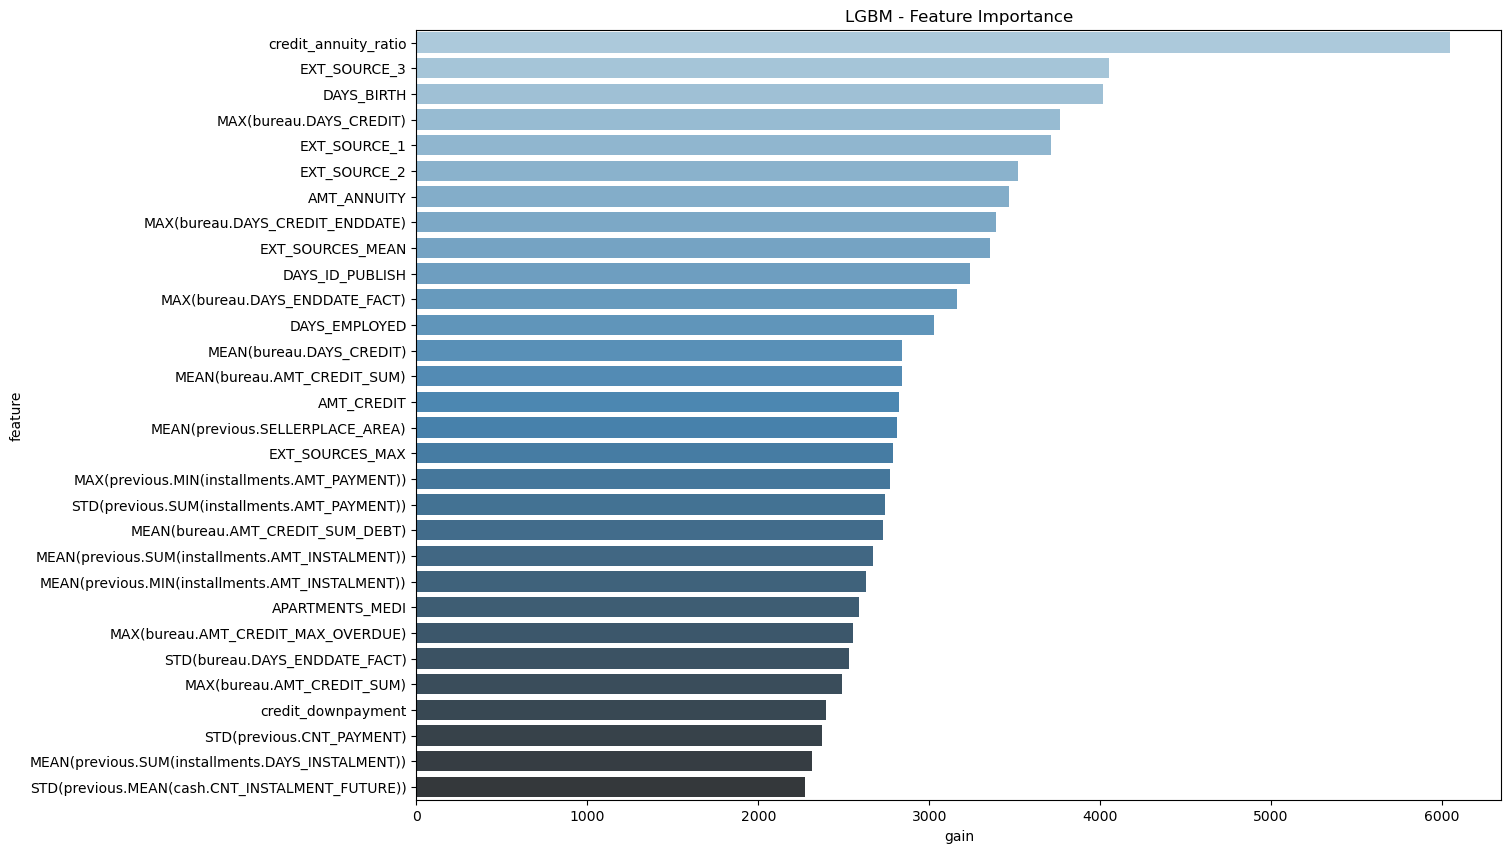

In [ ]:
# plot top 30 feat_importance. make sure the plot is light blue
plt.figure(figsize=(14, 10))
sns.barplot(
    x="gain",
    y="feature",
    data=feat_importance.sort_values(by="gain", ascending=False)[:30],
    palette="Blues_d",
)
plt.title("LGBM - Feature Importance")
plt.show()

## CATBoost Finetune

In [ ]:
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import time
import matplotlib.pyplot as plt
import numpy as np


class IterationTrackingCallback:
    def __init__(self):
        self.start_time = time.time()
        self.best_scores = []
        self.best_parameters = []

    def __call__(self, res):
        iteration_time = time.time() - self.start_time
        print(f"\nIteration completed in {iteration_time:.2f} seconds.")

        best_score_so_far = (
            -res.fun
        )  # Note: Depending on the scoring, you might need to negate this value
        self.best_scores.append(best_score_so_far)
        print(f"Best score so far: {best_score_so_far:.4f}")

        best_params_so_far = dict(zip(res.space.dimension_names, res.x))
        self.best_parameters.append(best_params_so_far)
        print("Best parameters so far:")
        for param_name, param_value in best_params_so_far.items():
            print(f"{param_name}: {param_value}")

        self.start_time = time.time()


# Initialize the callback for CatBoost
iteration_callback_catboost = IterationTrackingCallback()

# Define the CatBoostClassifier
model_catboost = CatBoostClassifier(task_type="GPU", random_state=42, verbose=0)

# Define the search space for CatBoost
search_spaces_catboost = {
    "bootstrap_type": Categorical(["Bernoulli"]),  # Based on your best parameters
    "border_count": Integer(150, 250),  # Around 209
    "depth": Integer(4, 12),  # Around 6
    "iterations": Integer(300, 600),  # Around 450
    "l2_leaf_reg": Real(3, 10),  # Around 6.33
    "learning_rate": Real(0.05, 0.1),  # Around 0.0756
    "subsample": Real(0.8, 1.0),  # Around 0.929
}

# Set up BayesSearchCV for CatBoost
opt_catboost = BayesSearchCV(
    estimator=model_catboost,
    search_spaces=search_spaces_catboost,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    n_jobs=1,
    return_train_score=True,
    refit=True,
    random_state=42,
)

# Fit the model
opt_catboost.fit(X_train, y_train, callback=[iteration_callback_catboost])

# Plot the improvement of scores over iterations for CatBoost
plt.figure(figsize=(10, 6))
plt.plot(iteration_callback_catboost.best_scores, marker="o")
plt.title("Improvement of Best AUC Score over Iterations for CatBoost")
plt.xlabel("Iteration")
plt.ylabel("Best AUC Score")
plt.grid(True)
plt.show()

<img src="../images/CAT_AUC_scores.png" alt="Alternative text" />


**CATBOOST**

**Best score: 0.7871** 
- bootstrap_type: Bernoulli
- depth: 6
- iterations: 2000
- l2_leaf_reg: 10.0
- leaf_estimation_iterations: 7
- learning_rate: 0.06832509053834994
- max_bin: 246
- subsample: 1.0


### CATBoost Kfold

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc


def kfold_catboost_sklearn(
    X_train,
    y_train,
    cat_features,
    X_test=None,
    y_test=None,
    NUM_FOLDS=5,
    RANDOM_SEED=50,
    STRATIFIED_KFOLD=False,
    CATBOOST_PARAMS={},
):
    print(f"Train/valid shape: {X_train.shape, y_train.shape}")

    folds = (
        StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        if STRATIFIED_KFOLD
        else KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    )

    oof_preds = np.zeros(X_train.shape[0])
    if X_test is not None:
        sub_preds = np.zeros(X_test.shape[0])
    importance_df = pd.DataFrame()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = CatBoostClassifier(
            **CATBOOST_PARAMS, random_seed=RANDOM_SEED, cat_features=cat_features
        )
        clf.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=400,
            early_stopping_rounds=100,
        )

        proba_preds_valid = clf.predict_proba(valid_x)[:, 1]
        oof_preds[valid_idx] = proba_preds_valid

        if X_test is not None:
            sub_preds += clf.predict_proba(X_test)[:, 1] / folds.n_splits

        fold_importance = pd.DataFrame(
            {
                "feature": train_x.columns.tolist(),
                "importance": clf.get_feature_importance(),
                "fold": n_fold + 1,
            }
        )
        importance_df = pd.concat([importance_df, fold_importance], axis=0)

        print(
            "Fold %2d AUC : %.6f"
            % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]))
        )
        gc.collect()

    print("Full AUC score %.6f" % roc_auc_score(y_train, oof_preds))

    if X_test is not None and y_test is not None:
        print("Test AUC score: %.6f" % roc_auc_score(y_test, sub_preds))

    return (
        importance_df.groupby("feature")
        .importance.mean()
        .sort_values(ascending=False)
        .reset_index()
    )


# Example usage
cat_features = [
    index for index, col in enumerate(X_train.columns) if X_train[col].dtype == "object"
]

CATBOOST_PARAMS = {
    "bootstrap_type": "Bernoulli",
    "max_bin": 250,
    "depth": 6,
    "iterations": 3000,
    "l2_leaf_reg": 10.0,
    "learning_rate": 0.05,
    "subsample": 1.0,
    "verbose": 0,
    "task_type": "GPU",
    "devices": "0",
}

feat_importance = kfold_catboost_sklearn(
    X_train,
    y_train,
    cat_features,
    X_test,
    y_test,
    NUM_FOLDS=10,
    STRATIFIED_KFOLD=True,
    CATBOOST_PARAMS=CATBOOST_PARAMS,
)
print(feat_importance)

Train/valid shape: ((230633, 206), (230633, 1))
0:	learn: 0.6385285	test: 0.6384329	best: 0.6384329 (0)	total: 12.3ms	remaining: 36.9s
400:	learn: 0.2293855	test: 0.2414033	best: 0.2413950 (397)	total: 3.14s	remaining: 20.3s
800:	learn: 0.2201107	test: 0.2404001	best: 0.2404001 (800)	total: 6.34s	remaining: 17.4s
bestTest = 0.2403658451
bestIteration = 819
Shrink model to first 820 iterations.
Fold  1 AUC : 0.778607
0:	learn: 0.6385049	test: 0.6386596	best: 0.6386596 (0)	total: 8.28ms	remaining: 24.8s
400:	learn: 0.2297329	test: 0.2411016	best: 0.2411016 (400)	total: 3.19s	remaining: 20.7s
800:	learn: 0.2206214	test: 0.2395202	best: 0.2395046 (798)	total: 6.34s	remaining: 17.4s
1200:	learn: 0.2134034	test: 0.2387704	best: 0.2387704 (1200)	total: 9.54s	remaining: 14.3s
1600:	learn: 0.2070944	test: 0.2387050	best: 0.2386583 (1519)	total: 12.6s	remaining: 11s
bestTest = 0.2386583215
bestIteration = 1519
Shrink model to first 1520 iterations.
Fold  2 AUC : 0.783003
0:	learn: 0.6385180	test

- Train AUC score 0.788144
- Test AUC score: 0.790193

<Figure size 1400x1000 with 0 Axes>

<Axes: xlabel='importance', ylabel='feature'>

Text(0.5, 1.0, 'CATBoost - Feature Importance')

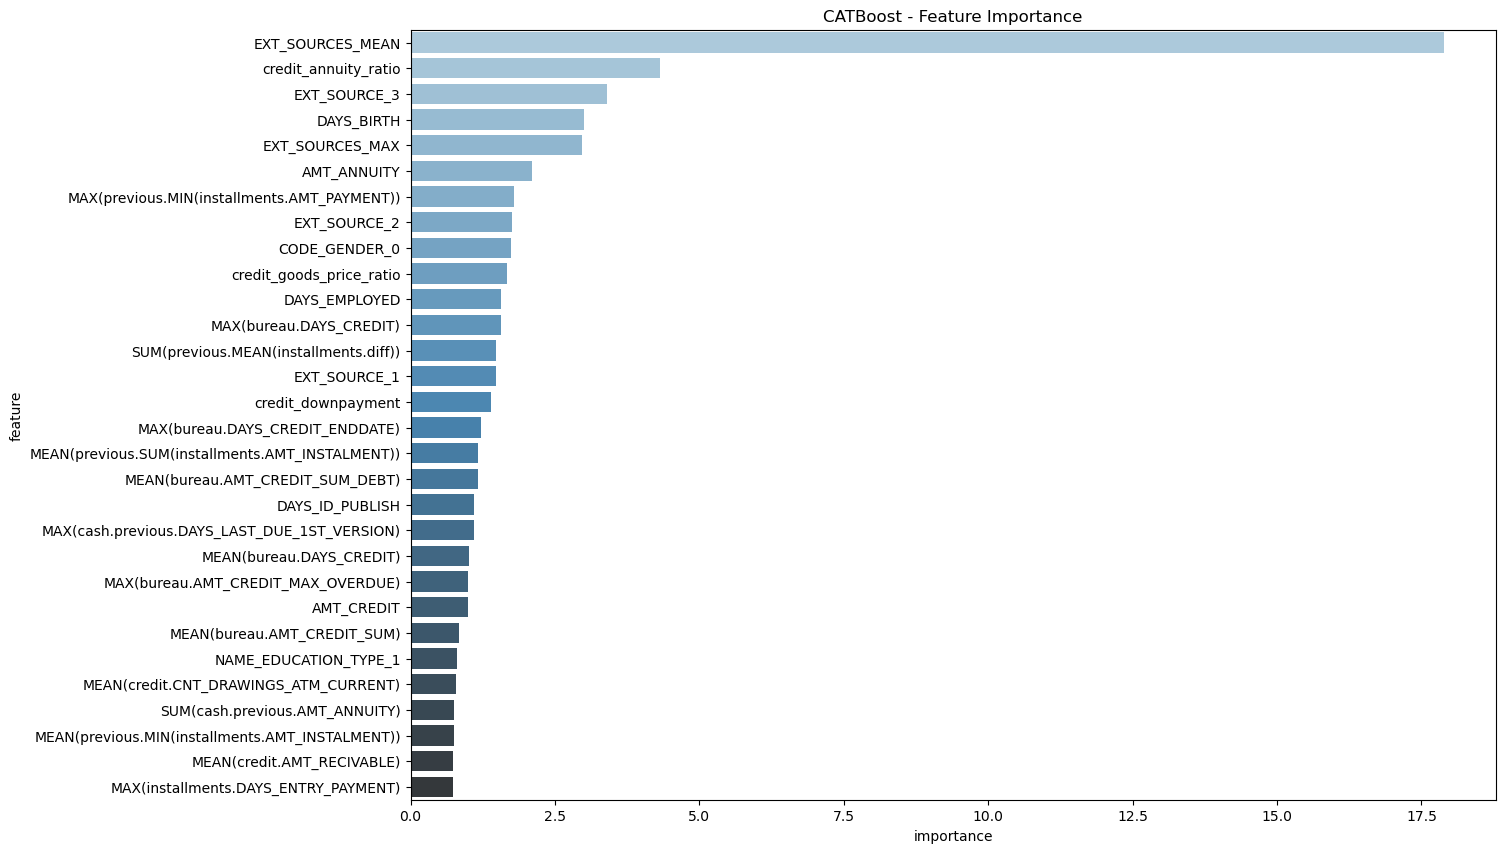

In [ ]:
# plot top 30 feat_importance
plt.figure(figsize=(14, 10))
sns.barplot(
    x="importance",
    y="feature",
    data=feat_importance.sort_values(by="importance", ascending=False)[:30],
    palette="Blues_d",
)
plt.title("CATBoost - Feature Importance")
plt.show()

## Fit all the models with the best parameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Define models with names
models = {
    "LGBM": LGBMClassifier(
        boosting_type="goss",
        n_estimators=10000,
        learning_rate=0.005134,
        num_leaves=54,
        max_depth=10,
        subsample_for_bin=240000,
        reg_alpha=0.436193,
        reg_lambda=0.479169,
        colsample_bytree=0.508716,
        min_split_gain=0.024766,
        subsample=1,
        is_unbalance=False,
        silent=-1,
        verbose=-1,
    ),
    "CatBoost": CatBoostClassifier(
        bootstrap_type="Bernoulli",
        max_bin=246,
        depth=6,
        iterations=2000,
        l2_leaf_reg=10.0,
        learning_rate=0.1,
        subsample=1.0,
        verbose=0,
        task_type="GPU",
        devices="0",
        random_state=42,
    ),
    "XGB": XGBClassifier(
        colsample_bylevel=0.756658,
        colsample_bynode=1.0,
        colsample_bytree=0.869961,
        gamma=0,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=1,
        n_estimators=1200,
        reg_alpha=1,
        reg_lambda=1.0,
        subsample=0.91,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        tree_method="gpu_hist",
    ),
}

fitted_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model

print("Models have been fitted.")

LGBMClassifier(boosting_type='goss', colsample_bytree=0.508716,
               is_unbalance=False, learning_rate=0.005134, max_depth=10,
               min_split_gain=0.024766, n_estimators=10000, num_leaves=54,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1, subsample=1,
               subsample_for_bin=240000, verbose=-1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.756658, colsample_bynode=1.0,
              colsample_bytree=0.869961, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Models have been fitted.


In [ ]:
fitted_models

{'LGBM': LGBMClassifier(boosting_type='goss', colsample_bytree=0.508716,
                is_unbalance=False, learning_rate=0.005134, max_depth=10,
                min_split_gain=0.024766, n_estimators=10000, num_leaves=54,
                reg_alpha=0.436193, reg_lambda=0.479169, silent=-1, subsample=1,
                subsample_for_bin=240000, verbose=-1),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x7f0c29fa11e0>,
 'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.756658, colsample_bynode=1.0,
               colsample_bytree=0.869961, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None, gamma=0,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max

In [ ]:
# Save all of the fitted models
import joblib

# Save the fitted models to disk
for name, model in fitted_models.items():
    joblib.dump(model, f"../models/{name}_finetuned.joblib")

model_names = ["LGBM", "CatBoost", "XGB"]

# Load each model from the saved .joblib files
for name in model_names:
    fitted_models[name] = joblib.load(f"../models/{name}_finetuned.joblib")

<Axes: >

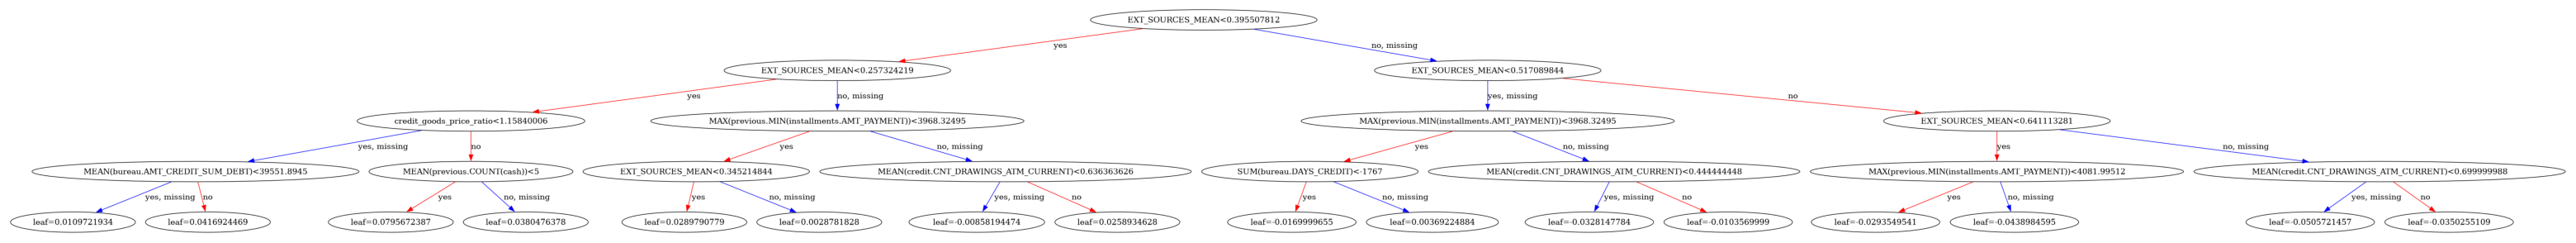

In [ ]:
import xgboost as xgb

fig, ax = plt.subplots(figsize=(40, 30))
xgb.plot_tree(fitted_models['XGB'],  ax=ax)
plt.savefig("tree_high_res.png", dpi=1000) 

<Axes: >

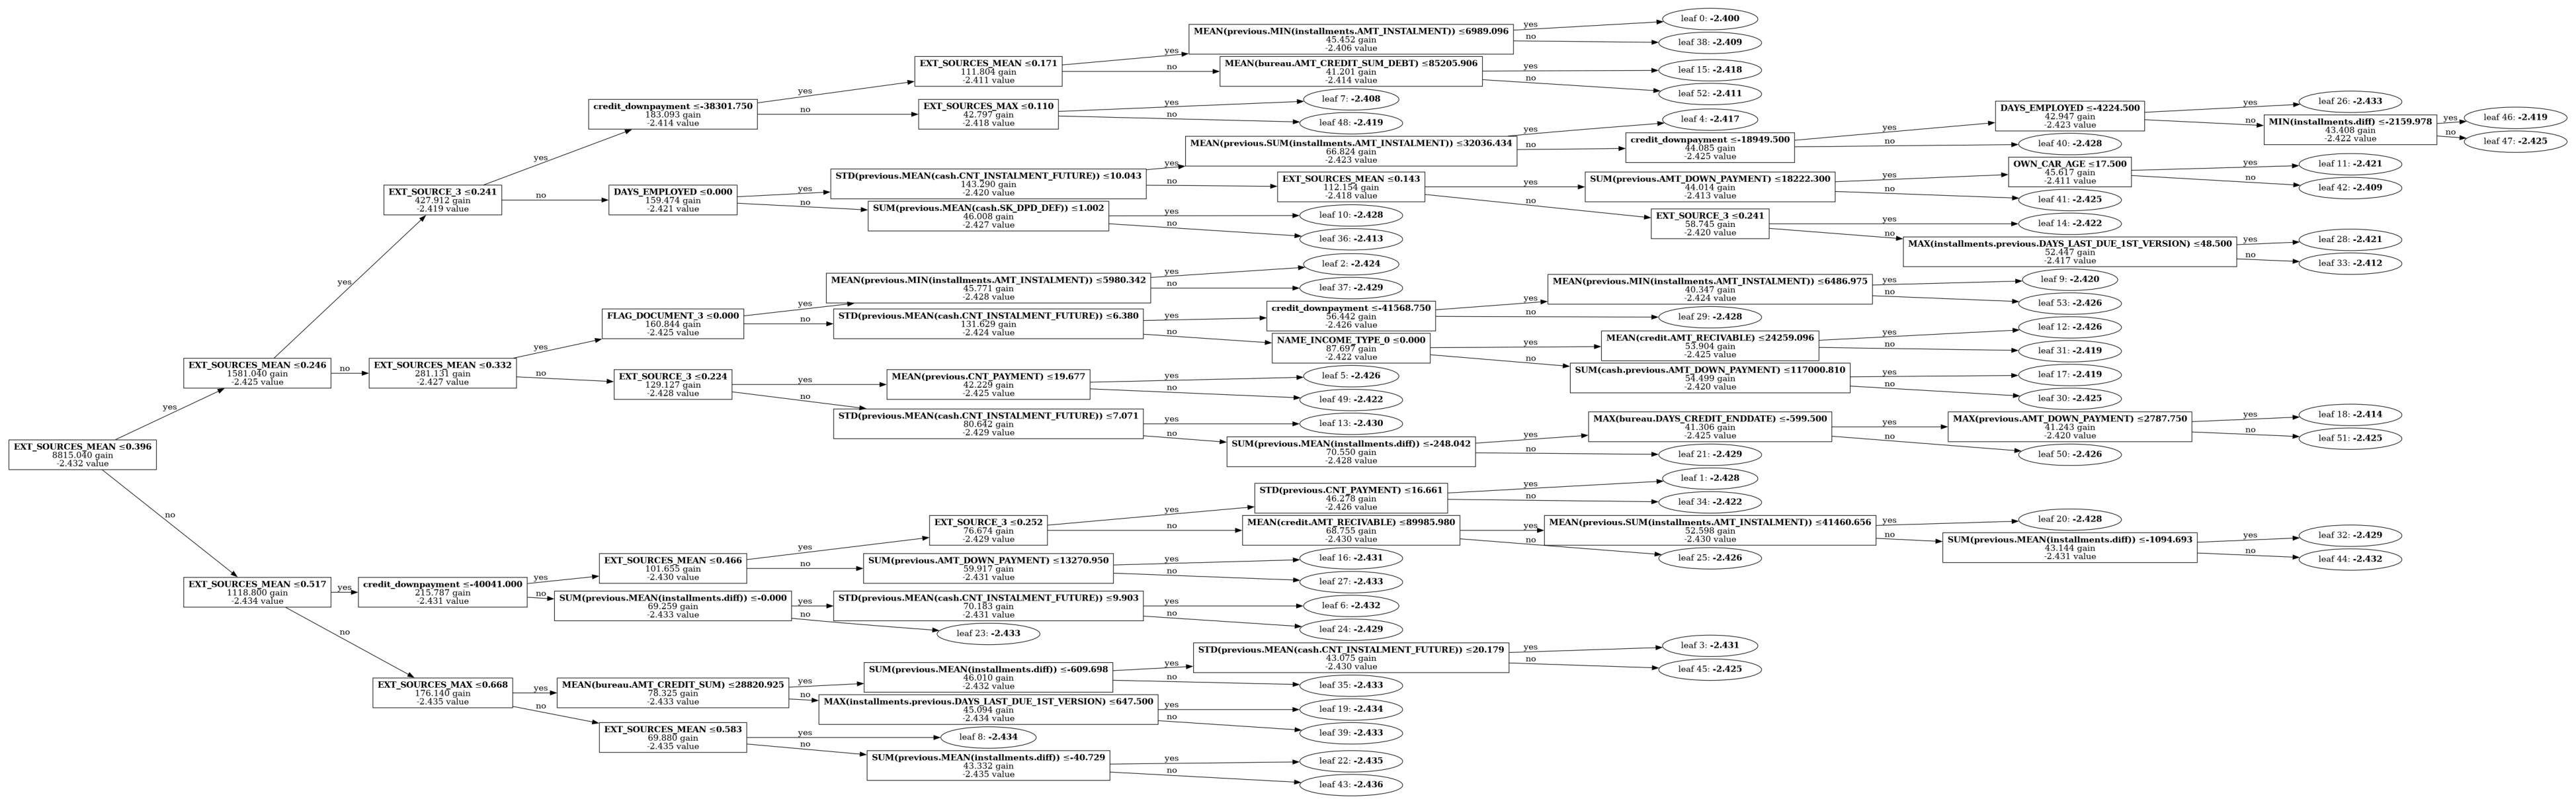

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Visualize the first tree
lgb.plot_tree(fitted_models['LGBM'], tree_index=0, figsize=(50, 50), show_info=['split_gain', 'internal_value'])
plt.show()


<Figure size 3000x3000 with 0 Axes>

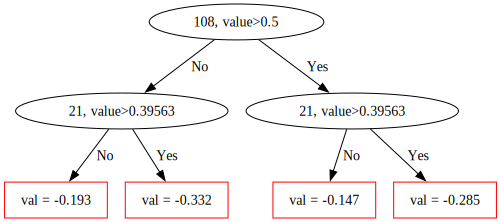

In [ ]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt


tree_index = 0

# Save the plot to a file
plt.figure(figsize=(30, 30))
fitted_models['CatBoost'].plot_tree(tree_idx=tree_index)
plt.savefig('catboost_tree_high_res.png', dpi=1000)
plt.close()


Confusion matrix

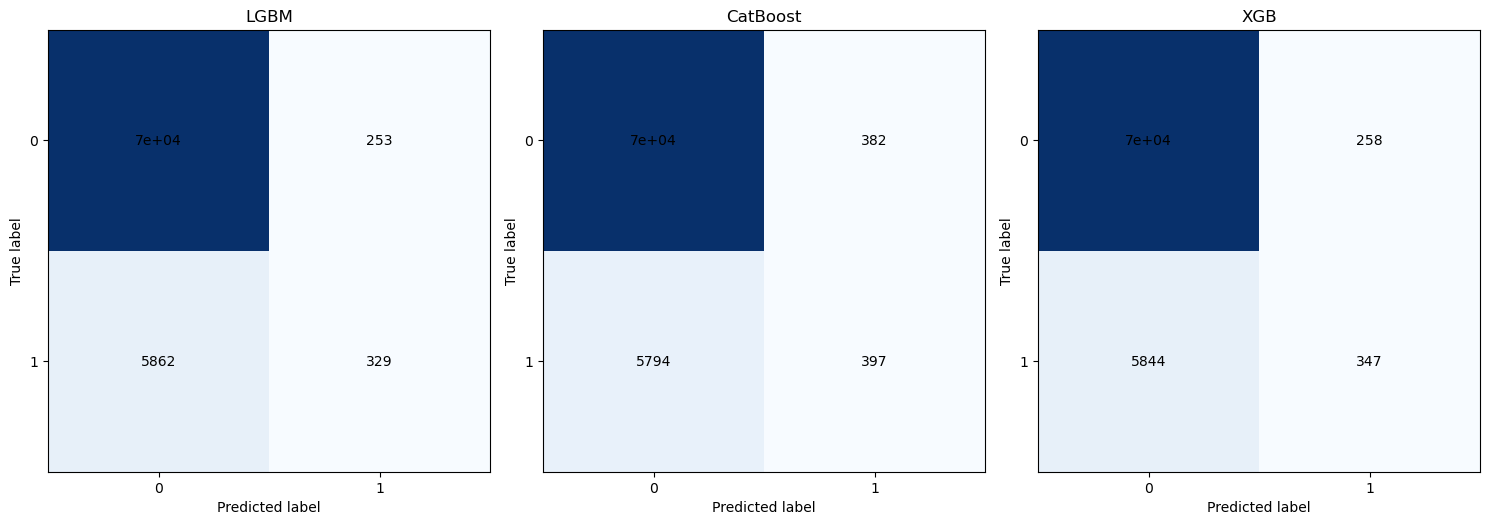

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Placeholder for confusion matrix plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 20))
for ax, (name, model) in zip(axes.flatten(), fitted_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)  # Turn off the colorbar
    ax.title.set_text(name)
    disp.im_.set_cmap("Blues")  # Set the colormap to 'Blues' or any other colormap

    # Change the color of the text in the confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            disp.text_[i, j].set_color(
                "black"
            )  # Change 'yellow' to your color of choice

plt.tight_layout()
plt.show()

Feature Importances

In [ ]:
import plotly.graph_objects as go

# Define the matrix values for each model
values_lgbm = [["7e04", 253], [5862, 329]]
values_catboost = [["7e04", 382], [5794, 397]]
values_xgb = [["7e04", 258], [5844, 347]]

# Custom colorscale from grey to dark orange
colorscale = [
    [0, 'black'],        # Grey for lower values
    [1, 'Blues']   # Dark orange for higher values
]

# Create a function to plot a confusion matrix
def plot_confusion_matrix(values, model_name):
    fig = go.Figure(data=go.Heatmap(
            z=values,
            x=['Predicted 0', 'Predicted 1'],
            y=[' (0)', ' (1)'],
            colorscale="Greys",
            showscale=False,
            text=values,
            texttemplate="%{text}",
            hoverinfo="text"
        ))
    fig.update_layout(
        title=f'Confusion Matrix for {model_name}',
        xaxis_title="Predicted Label",
        yaxis_title="True Label",
        template='plotly_dark',
        width=600,
        height=600
    )
    fig.update_traces(showscale=False) # Hide color scale if not needed
    fig.show()

# Plot each model's confusion matrix
plot_confusion_matrix(values_lgbm, 'LGBM')
plot_confusion_matrix(values_catboost, 'CatBoost')
plot_confusion_matrix(values_xgb, 'XGBoost')


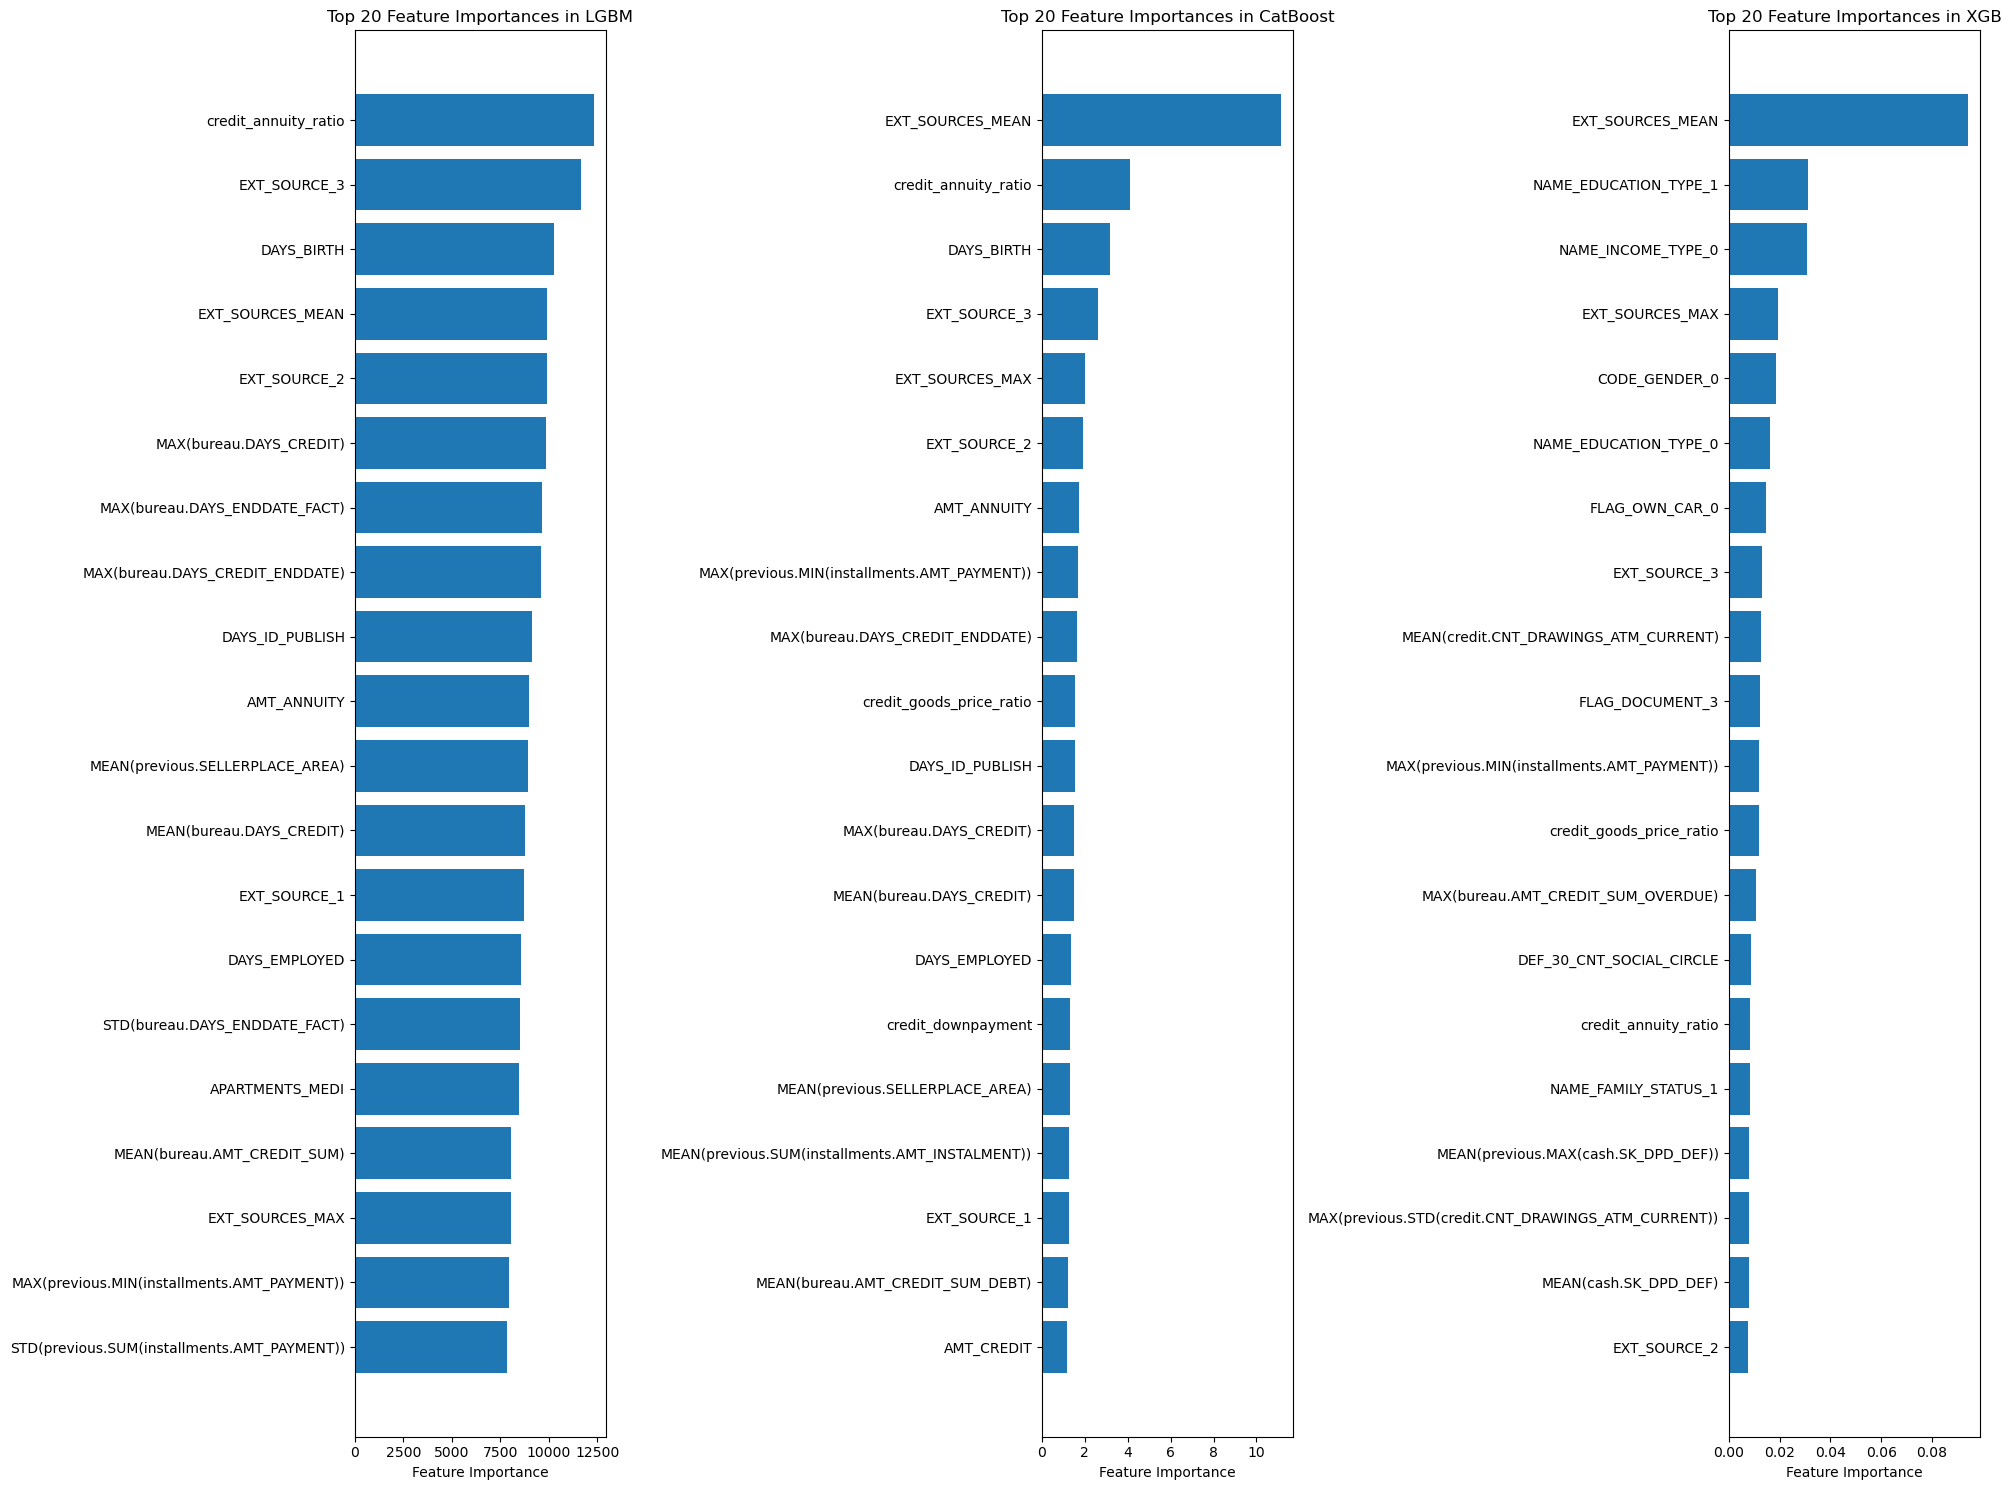

In [ ]:
# Assuming X_train is a DataFrame that includes feature names as columns
feature_names = X_train.columns

# Plotting feature importances for each model
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
for ax, (name, model) in zip(axes.flatten(), fitted_models.items()):
    # Check if the model has 'feature_importances_'
    if hasattr(model, "feature_importances_"):
        # Get feature importances
        importances = model.feature_importances_
        # Indices of top 20 features
        indices = np.argsort(importances)[-20:]
        # Bar plot for feature importances
        ax.barh(range(len(indices)), importances[indices], align="center")
        # Set the y-ticks to be the feature names
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel("Feature Importance")
        ax.set_title(f"Top 20 Feature Importances in {name}")
    else:
        ax.set_title(f"{name} does not support feature importances")
        ax.axis("off")

plt.tight_layout()
plt.show();

## Blending Fine-tuned Models

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

X_blend_train, X_blend_test, y_blend_train, y_blend_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

n_models = len(fitted_models)
predictions = np.zeros((X_blend_test.shape[0], n_models))

for name, model in models.items():
    print(model.__class__.__name__)
    # Randomly select half of the features for each model to train on
    random_features = np.random.choice(
        X_blend_train.columns, size=len(X_blend_train.columns) // 2, replace=False
    )

    # Train the model on these features
    model.fit(X_blend_train[random_features], y_blend_train)

    # Predict on the test set
    predictions[:, i] = model.predict_proba(X_blend_test[random_features])[:, 1]

# Average the predictions
final_blend_predictions = np.mean(predictions, axis=1)

# Evaluate (Example using AUC)
print(f"Blended Model AUC: {roc_auc_score(y_blend_test, final_blend_predictions)}")

LGBMClassifier


LGBMClassifier(boosting_type='goss', colsample_bytree=0.508716,
               is_unbalance=False, learning_rate=0.005134, max_depth=10,
               min_split_gain=0.024766, n_estimators=10000, num_leaves=54,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1, subsample=1,
               subsample_for_bin=240000, verbose=-1)

CatBoostClassifier


XGBClassifier


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=1.0, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08807219785563987,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Blended Model AUC: 0.7755652793814815
